# Analyse and visualize data

In [24]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
matplotlib.style.use('ggplot')

## Load clean data

In [25]:
df = pd.read_csv('twitter_archive_master.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990 entries, 0 to 1989
Data columns (total 24 columns):
tweet_id                 1990 non-null int64
in_reply_to_status_id    1990 non-null int64
in_reply_to_user_id      1990 non-null int64
timestamp                1990 non-null object
source                   1990 non-null object
text                     1990 non-null object
expanded_urls            1990 non-null object
rating_numerator         1990 non-null float64
rating_denominator       1990 non-null int64
name                     1388 non-null object
favorite_count           1990 non-null int64
retweet_count            1990 non-null int64
jpg_url                  1990 non-null object
img_num                  1990 non-null int64
p1                       1990 non-null object
p1_conf                  1990 non-null float64
p1_dog                   1990 non-null bool
p2                       1990 non-null object
p2_conf                  1990 non-null float64
p2_dog                   

In [26]:
# Reapply type transformation which have been lost from wrangling while saving to csv.
#df['source'] = df['source'].astype('category')
#df['life_stage'] = df['life_stage'].astype('category')

# Index on time.
#df.set_index('timestamp', inplace=True)
#len(df)

## Analyze
### Insight
#### Insight #1: Which dog breed get the highest rating

In [27]:
df[df.p1_dog == True].groupby('p1').rating_numerator.mean().nlargest(3)

p1
soft-coated_wheaten_terrier    25.454545
West_Highland_white_terrier    15.642857
Great_Pyrenees                 14.928571
Name: rating_numerator, dtype: float64

**Terrier** and **Great Pyrenees** are the breeds getting the highest median rating.

In [28]:
df.sort_values(by = 'rating_numerator', ascending = False).iloc[:5,14:23]

,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1438,bow_tie,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False
660,microphone,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False
1612,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False
1508,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True
865,teddy,0.662908,False,crib,0.031891,False,chow,0.025438,True


When giving a look to the five first dogs getting the highest rating, we see that all the three algotrithms failed to predict the race:
* For the three first dog prediction result came out to be False)
* For the fourth dog P1 predicts a labrador, P2 predicts a Chihuahua and P3 predicts American Stafforshire Terrier. But the confidence interval of P1 is better by a factor 4 so we would favor P1 in that case. Investigating more on outcome and confidence interval should help to decide which algorithm to trust.

#### Insight #2: Which dog stage get the highest rating

In [29]:
df.groupby('life_stage').rating_numerator.mean().sort_values(ascending=False)

life_stage
doggo,puppo      13.000000
None             12.454578
puppo            12.000000
floofer          12.000000
doggo            11.888889
doggo,pupper     11.000000
doggo,floofer    11.000000
pupper           10.636798
Name: rating_numerator, dtype: float64

**Doggo,Puppo** is getting the highest median rating.

#### Insight #3: what's the correlation between favorites, retweet and rating

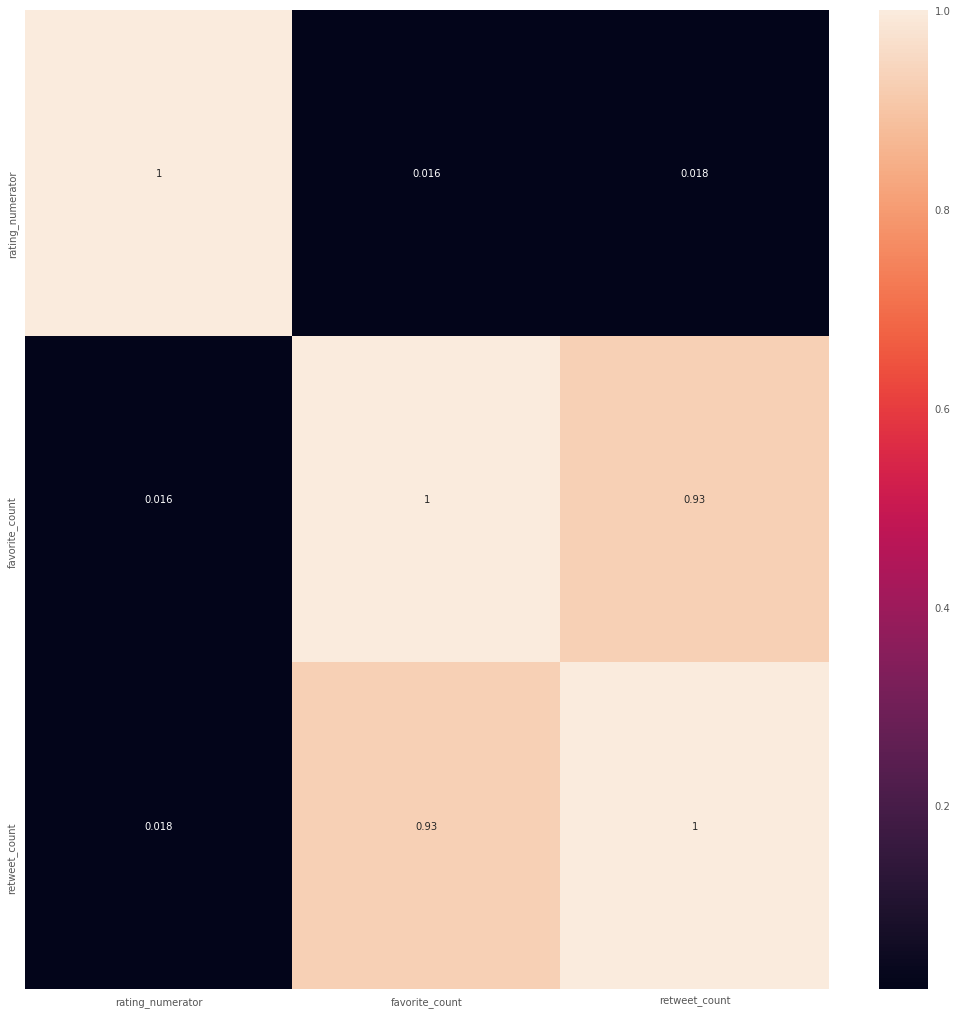

In [30]:
f,ax = plt.subplots(figsize=(18, 18));
corr = df[['rating_numerator','favorite_count','retweet_count']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True)

# Save the figure for the reports
plt.savefig('favorite_vs_retweet_vs_rating.jpg')


#### Observation

* There's a strong positive correlation between favorite and retweet
* Rating is not influence by any other 'count' variable

### Visualization

#### Visualization #1: Rating per dog stage.

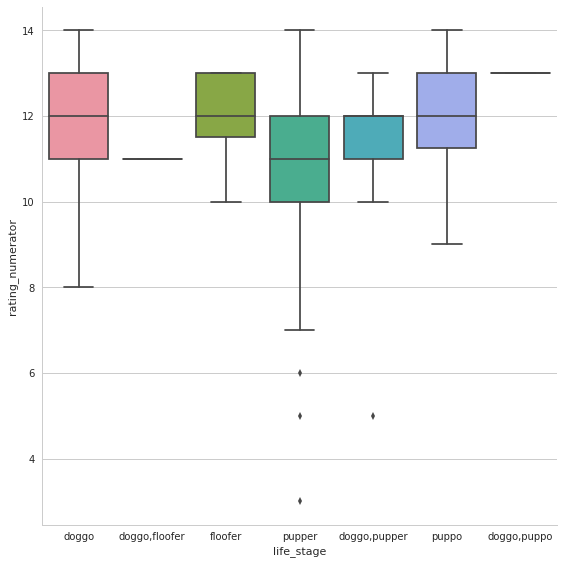

In [31]:
# Rename for a nicer display
df.loc[df.life_stage == 'None', 'life_stage'] = 'Unknown'

sns.set(style="whitegrid")

# Set boxplot parameters and properties to my liking
sns.factorplot(kind='box',        
               y='rating_numerator',       
               x='life_stage', 
               data=df[df['life_stage'] != 'Unknown'], 
               size=8,               
               aspect=1,   
               legend_out=True)

# Save the figure for the reports
plt.savefig('rating_per_dog_stage.jpg')


#### Observation

**Pupper** got the lowest rating compare to the others single stage and also have some outliers. 
**Puppo** performs slightly better than **floofer** and **doggo**. Data for those three are a bit skewed but this won't change the conclusion.

Since there's only one of each, the mixed stages **doggo.floofer** and **doggo,puppo** are not representative (about **doggo,puppo** we can consider the single score to be in the range of **Puppo**, thus confirming our observation about **Puppo** performing slightly better). **dogoo,pupper** performs realtively the same than **Pupper** (lowest rating compare to the others single stage).

#### Visualization #2: Accuracy of the breed

In [32]:
df_prediction = df.iloc[:,14:23]

# P1
df_p1 = pd.melt(df_prediction, value_vars=['p1_conf'],
          var_name='algorithm', value_name='confidence_interval')
df_p1['valid'] = df_prediction['p1_dog']

# P2
df_p2 = pd.melt(df_prediction, value_vars=['p2_conf'],
          var_name='algorithm', value_name='confidence_interval')
df_p2['valid'] = df_prediction['p2_dog']

# P3
df_p3 = pd.melt(df_prediction, value_vars=['p3_conf'],
          var_name='algorithm', value_name='confidence_interval')
df_p3['valid'] = df_prediction['p3_dog']

df_prediction_melt = pd.concat([df_p1, df_p2, df_p3], ignore_index= True)
df_prediction_melt['algorithm'] = df_prediction_melt['algorithm'].str[:2]
df_prediction_melt.head()


,algorithm,confidence_interval,valid
0,p1,0.999091,True
1,p1,0.989154,False
2,p1,0.980815,False
3,p1,0.825670,True
4,p1,0.676376,True


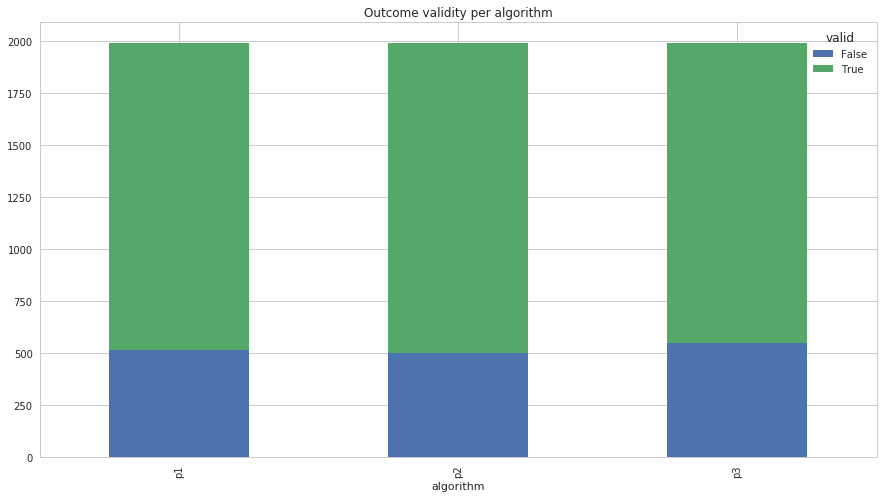

In [33]:
df_plot = df_prediction_melt.groupby(['algorithm','valid']).size().reset_index().pivot(columns='valid', index='algorithm', values=0)
df_plot.plot(kind='bar',stacked=True, figsize=(15,8), title='Outcome validity per algorithm')

# Save the figure for the reports
plt.savefig('algorithms_outcome.jpg')


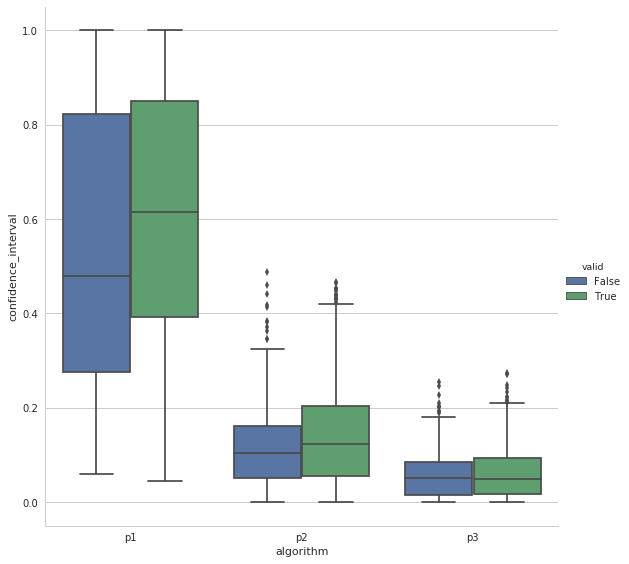

In [34]:
# Set boxplot parameters and properties to my liking
#sns.boxplot(x="algorithm", y="confidence_interval", hue="valid", data=df_prediction_melt, palette="bright").set_title('Success Rates of Algorithms', size= 1)


#plt.figure(figsize=(5, 8))

sns.factorplot(kind='box',     
               y='confidence_interval',       
               x='algorithm', 
               hue='valid',
               data=df_prediction_melt, 
#               data=df, 
               size=8,               
               aspect=1,   
               legend_out=True)

# Save the figure for the reports
plt.savefig('algorithms_confidence.jpg')


In [35]:
df.sort_values(by = 'rating_numerator', ascending = False).head(3).jpg_url

1438    https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg
660     https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg
1612    https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg
Name: jpg_url, dtype: object

Image of the three first dogs:
![first](https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg)
![first](https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg)
![first](https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg)

##### Observation:

From the validity of the outcome and the distribution of confidence interval of each prediction algorithm we remark:

* All the algorithm perform more or less the same with a third of the result caming out false.
* Confidence interval of P1 is definitly higher than those of P2 and P3.

By visual observation, we also see that for the same picture the three algorithm may end up with a different prediction. Thus, we could rely on P1 outcome to draw conclusion from the breed variable.


Now by just looking to the picture, we can figure out the complexities the arlgoryhtms are facing so increasing their accuracy might be difficult.

As of insight#1, we will stick to **Clumber** and **Terrier** being the breeds which get the highest median rating.